## Character Level ConvNets project

## Load Datasets


In [161]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import copy


In [162]:
df = pd.read_csv('./yahoo_answers_csv/train.csv', header = None, nrows = 1000)
Y_train = df[0]
df.drop(df.columns[0],axis=1,inplace=True)
df[df.columns[0]] = df[df.columns[0]].map(str) + df[df.columns[1]].map(str)+ df[df.columns[2]].map(str)
df.drop(df.columns[[1,2]],axis=1,inplace=True)
l = 1014
X_train = df[df.columns[0]].apply(lambda x: x[:l] ) # 5
print(X_train)


0      why doesn't an optical mouse work on a glass t...
1      What is the best off-road motorcycle trail ?lo...
2      What is Trans Fat? How to reduce that?I heard ...
3      How many planes Fedex has?I heard that it is t...
4      In the san francisco bay area, does it make se...
5      What's the best way to clean a keyboard?I have...
6      Why do people blush when they are embarrassed?...
7      Is Lin Qingxia (aka Brigitte Lin) "the most be...
8      What is the origin of "foobar"?I want to know ...
9      How the human species evolved?How the human sp...
10     Who said the statement below and what does it ...
11     How do I find an out of print book?When I was ...
12     What are some tips on finding a good mortgage ...
13     what's the best way to create a bootable windo...
14     what is the reason for the increasing divorce ...
15     What is an "imaginary number"?What is an "imag...
16     Faxing a pizzawould we be able to fax a pizza ...
17     What are good sources to

In [163]:
def oneHotEncoder(x):
    idxs = np.fromstring(x,dtype=np.uint8)-97
    one_hot = tf.one_hot(idxs, 70, dtype=tf.uint8)
    return one_hot.eval()

sess = tf.InteractiveSession()
oneHotEncoder("hello")
X = X_train.apply(lambda x: oneHotEncoder(x))
print(X.shape)
print(Y_train.shape)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


(1000,)
(1000,)


In [157]:
print(X.shape, X[3].shape)
print(Y_train.shape)
X_int = np.zeros((X.shape[0], L, X[0].shape[1]), dtype=int)
print(X_int.shape)
for idx, x_val in enumerate(X):
    #print(x_val.shape)
    x_val2 = copy.deepcopy(x_val)
    x_val2.resize((L, X[0].shape[1]))
    X_int[idx] = x_val2
#print(X_int)
print(X_int[78][0])
#print(X_int.dtype.base_dtype)
print(X_int.shape[0])

Y_train = Y_train.reshape(Y_train.shape[0],1)
print(Y_train.shape)


((100,), (482, 70))
(100, 1)
(100, 1014, 70)
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
100
(100, 1)


('x.shape', TensorShape([Dimension(None), Dimension(1014), Dimension(70)]))
('y.shape', TensorShape([Dimension(None), Dimension(1)]))
('X_int[0, :,  :]', (1014, 70))
('X.shape:', (100, 1014, 70), 'Y.shape:', (100, 1))
Cost after epoch 0: 2.429363
('X.shape:', (100, 1014, 70), 'Y.shape:', (100, 1))
Cost after epoch 1: 2.189119
('X.shape:', (100, 1014, 70), 'Y.shape:', (100, 1))
Cost after epoch 2: 2.187546
('X.shape:', (100, 1014, 70), 'Y.shape:', (100, 1))
Cost after epoch 3: 2.187456
('X.shape:', (100, 1014, 70), 'Y.shape:', (100, 1))
Cost after epoch 4: 2.187456


NameError: name 'learning_rate' is not defined

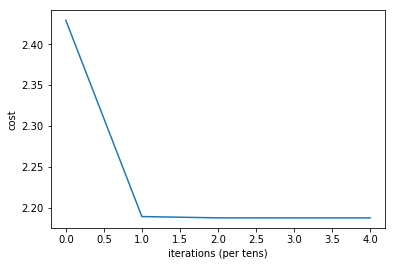

In [159]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    #print('X.shape:', X.shape, 'Y.shape:', Y.shape)
    shuffled_X = X[permutation, :, :]
    
    shuffled_Y = Y[permutation, :] #.reshape((m, Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
L = l # 1014 
NUM_FILTERS = 256 # 1024 for large, 256 for small
NOUT = 1024 # 2048 for large, 1024 for small 
NUM_CHAR_OPTIONS = 70
STD_INIT = 0.02 # 0.02 for large, 0.05 for small 
x = tf.placeholder(tf.float32, [None, L, NUM_CHAR_OPTIONS])
y = tf.placeholder(tf.int64, [None, 1])
is_training = tf.placeholder(tf.bool)

num_epochs = 5
minibatch_size = 10
seed = 1
num_categories = 10
costs = [] 

def simple_model(x,y):    
    conv1 = tf.layers.conv1d(x, filters=NUM_FILTERS, kernel_size=7, strides=1, padding='SAME', 
                                   kernel_initializer=tf.initializers.random_normal(mean=0, stddev=STD_INIT), 
                                   # defaults to NWC
                                   activation=tf.nn.relu, reuse=None, name="conv1") 
    pool1 = tf.layers.max_pooling1d(conv1, pool_size=3, strides=1, padding='VALID', data_format='channels_last', name="pool1") 
    
    conv2 = tf.layers.conv1d(pool1, filters=NUM_FILTERS, kernel_size=7, strides=1, padding='SAME', 
                                   activation=tf.nn.relu, reuse=None, name="conv2") 
    pool2 = tf.layers.max_pooling1d(conv2, pool_size=3, strides=1, padding='VALID', data_format='channels_last', name="pool2")
    
    conv3 = tf.layers.conv1d(pool2, filters=NUM_FILTERS, kernel_size=3, strides=1, padding='SAME', 
                                   activation=tf.nn.relu, reuse=None, name="conv3") 
    
    conv4 = tf.layers.conv1d(conv3, filters=NUM_FILTERS, kernel_size=3, strides=1, padding='SAME', 
                                   activation=tf.nn.relu, reuse=None, name="conv4") 
    
    conv5 = tf.layers.conv1d(conv4, filters=NUM_FILTERS, kernel_size=3, strides=1, padding='SAME', 
                                   activation=tf.nn.relu, reuse=None, name="conv5") 
    
    conv6 = tf.layers.conv1d(conv5, filters=NUM_FILTERS, kernel_size=3, strides=1, padding='SAME', 
                                   activation=tf.nn.relu, reuse=None, name="conv6") 
    pool6 = tf.layers.max_pooling1d(conv6, pool_size=3, strides=1, padding='VALID', data_format='channels_last', name="pool6")
    
    fc7 = tf.contrib.layers.fully_connected(inputs=tf.contrib.layers.flatten(pool6), num_outputs=NOUT, reuse=None, 
                                      scope="fc7")
    fc8 = tf.contrib.layers.fully_connected(inputs=tf.contrib.layers.flatten(fc7), num_outputs=NOUT, reuse=None, 
                                      scope="fc8")
    fc9 = tf.contrib.layers.fully_connected(inputs=tf.contrib.layers.flatten(fc7), num_outputs=num_categories, reuse=None, 
                                      scope="fc9")
    
    return fc9

print('x.shape', x.shape)
print('y.shape', y.shape)
print('X_int[0, :,  :]', X_int[0, :,  :].shape)
y_out = simple_model(x,y)

# define our loss
total_loss = tf.nn.softmax_cross_entropy_with_logits(logits = y_out, labels = tf.one_hot(y, 10)) # yahoo 

# tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4).minimize(mean_loss)

init = tf.global_variables_initializer()
              
with tf.Session() as sess:
    sess.run(init)
    # should loop over minibatches
    for epoch in range(num_epochs):
        #print epoch
        epoch_cost = 0.                       # Defines a cost related to an epoch
        num_minibatches = int(X_int.shape[0] / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_int, Y_train, minibatch_size, seed)
        #minibatches = copy.deepcopy(minibatches_result)
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
                
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            ### START CODE HERE ### (1 line)
            #print('minibatch shapes:', minibatch_X.shape, minibatch_Y.shape)
            _ , minibatch_cost = sess.run([optimizer, mean_loss], feed_dict={x: minibatch_X, y: minibatch_Y})
            ### END CODE HERE ###
                
            epoch_cost += minibatch_cost / num_minibatches

        # Print the cost every epoch
        if epoch % 1 == 0: #100
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if epoch % 1 == 0: #5
            costs.append(epoch_cost)
                
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(5e-4))
    plt.show()

    # lets save the parameters in a variable
    #parameters = sess.run(parameters)
    #print ("Parameters have been trained!")

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(y_out), tf.argmax(y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_int, Y: Y_train}))
    #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

    #_ , minibatch_cost = sess.run([optimizer, cost], feed_dict={x: X_int, y: Y_train}) # minibatch_X, minibatch_Y
    #print ("Cost:", minibatch_cost)
    #result = sess.run(y_out)
    #print result
    